In [2]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp


In [3]:
dim_z = 8

In [4]:
prior = tfp.distributions.Independent(
            tfp.distributions.Normal(loc=tf.zeros(dim_z), scale=1.0),
            reinterpreted_batch_ndims=1,
        )
input_img = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(
                filters=32,
                kernel_size=3,
                strides=(2, 2),
                padding="valid",
                activation="relu",
            ) (input_img)
x = layers.Conv2D(
                filters=64,
                kernel_size=3,
                strides=(2, 2),
                padding="valid",
                activation="relu",
            ) (x)
x = layers.Flatten()(x)
x = layers.Dense(
                tfp.layers.IndependentNormal.params_size(dim_z),
                activation=None,
                name="z_params",
            )(x)
encoded = tfp.layers.IndependentNormal(
                dim_z,
                activity_regularizer=tfp.layers.KLDivergenceRegularizer(
                    prior, weight=2.0
                ),
                name="z_layer",)(x)

decoder_input = layers.InputLayer(input_shape=dim_z)(encoded)
x = layers.Dense(7 * 7 * 32, activation=None)(decoder_input)
x = layers.Reshape((7, 7, 32))(x)
x = layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding="same", activation="relu"
            )(x)
x = layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding="same", activation="relu"
            )(x)
x = layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding="same")(x)
x = layers.Flatten(name="x_params")(x)
decoded = tfp.layers.IndependentBernoulli((28, 28, 1), name="x_layer")(x)
vae = keras.Model(input_img, decoded)
vae.compile(optimizer='adam', loss=lambda x, y: -y.log_prob(x))
vae.summary()

2022-03-03 14:56:49.330664: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 13, 13, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 z_params (Dense)            (None, 16)                36880     
                                                                 
 z_layer (IndependentNormal)  ((None, 8),              0         
                              (None, 8))                         
                                                             

2022-03-03 14:56:49.536320: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [5]:
from stacked_mnist import StackedMNISTData, DataMode
import numpy as np

generator = StackedMNISTData(mode=DataMode.MONO_BINARY_MISSING, default_batch_size=2048)

x_train, y_train = generator.get_full_data_set(training=True)
x_test, y_test = generator.get_full_data_set(training=False)

# "Translate": Only look at "red" channel; only use the last digit. Use one-hot for labels during training
x_train = x_train[:, :, :, [0]]
y_train = keras.utils.to_categorical((y_train % 10).astype(np.int), 10)
x_test = x_test[:, :, :, [0]]
y_test = keras.utils.to_categorical((y_test % 10).astype(np.int), 10)

/var/folders/w2/4g3c4yrn38g2nwwdhjdlx6fc0000gn/T/ipykernel_17178/1236489056.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train = keras.utils.to_categorical((y_train % 10).astype(np.int), 10)
/var/folders/w2/4g3c4yrn38g2nwwdhjdlx6fc0000gn/T/ipykernel_17178/1236489056.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

In [6]:
vae.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
424/424 [==============================] - 26s 59ms/step - loss: 205.4533 - val_loss: 171.5074
Epoch 2/10
424/424 [==============================] - 26s 60ms/step - loss: 152.6982 - val_loss: 151.2722
Epoch 3/10
424/424 [==============================] - 25s 58ms/step - loss: 143.8776 - val_loss: 146.2056
Epoch 4/10
424/424 [==============================] - 28s 66ms/step - loss: 140.6587 - val_loss: 144.3297
Epoch 5/10
424/424 [==============================] - 28s 66ms/step - loss: 138.4539 - val_loss: 144.0818
Epoch 6/10
424/424 [==============================] - 27s 64ms/step - loss: 136.9515 - val_loss: 141.7054
Epoch 7/10
424/424 [==============================] - 27s 65ms/step - loss: 135.8286 - val_loss: 140.9304
Epoch 8/10
424/424 [==============================] - 28s 65ms/step - loss: 134.9621 - val_loss: 140.2076
Epoch 9/10
424/424 [==============================] - 27s 64ms/step - loss: 134.4118 - val_loss: 139.9753
Epoch 10/10
424/424 [=========================

In [17]:
generator_full = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=2048)
x_test, y_test = generator.get_random_batch(training=False, batch_size=2000)

# "Translate": Only look at "red" channel; only use the last digit. Use one-hot for labels during training
x_train = x_train[:, :, :, [0]]
x_test = x_test[:, :, :, [0]]

In [18]:
reconstructed = vae(x_test).mode()
bce = keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
losses = bce(x_test, reconstructed).numpy()
sum_losses = np.sum(losses, axis=(1, 2))
ind = np.argpartition(sum_losses, -10)[-10:] # Get the indices of the 10 largest losses

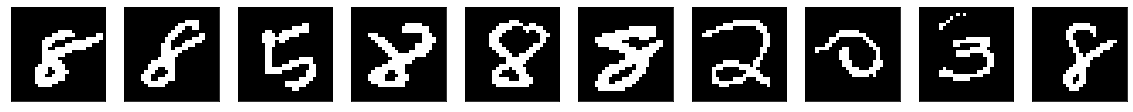

In [19]:
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[ind[i-1]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [24]:
N = 10000
z = np.random.randn(N, 8)
decoder = keras.Model(decoder_input, decoded)
decoded_z = decoder(z).mode()
bce = keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

In [25]:
losses = []
for i in range(x_test.shape[0]):
    x = x_test[i]
    x = np.repeat(x[np.newaxis, :, :, :], N, axis=0)
    loss = bce(x, decoded_z).numpy()
    loss = np.average(loss, axis=(1, 2))
    loss = np.exp(loss)
    loss = np.sum(loss)/N
    losses.append(loss)

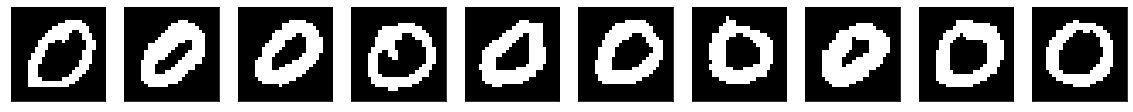

In [26]:
ind = np.argpartition(losses, -10)[-10:] # Get the indices of the 10 largest losses
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[ind[i-1]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()